In [1]:
import tensorflow as tf  
 
# Display the version
print(tf.__version__)    
 
# other imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Reshape, Add
from tensorflow.keras.layers import Layer, Softmax, ReLU
from tensorflow.keras.models import Model

# import KDL
from KDLayers import *

2.9.1


In [2]:
# Load cifar10
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# Normalize
x_train, x_test = x_train / 255.0, x_test / 255.0
 
# Flatten the label values
y_train, y_test = y_train.flatten(), y_test.flatten()

In [4]:
# Build the KDL model using the functional API
# input layer
i = Input(shape=x_train[0].shape)

# Convolution Layers
x = Conv2D(16, (3, 3), activation='relu', padding='same')(i)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Dropout
x = Dropout(0.2)(x)
x = Reshape((64,64))(x)
 
# KDL layers
x = KDLeftLayer(64, activation='relu')(x)
x = KDRightLayer(64, activation='relu')(x)

x = KDLeftLayer(64, activation='relu')(x)
x = KDRightLayer(64, activation='relu')(x)
 
# Another set of KDL layers for output
x = KDLeftLayer(2, activation='relu')(x)
x = KDRightLayer(5)(x)
x = Flatten()(x)
x = Softmax()(x)

# Build model
model = Model(i, x)
 
# Model summary
model.summary()

2022-11-18 11:18:33.015757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         147712

In [5]:
# Compile with learning rate 0.005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [6]:
# Training
hist_KDL = model.fit(x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
391/391 [==============================] - 105s 264ms/step - loss: 1.7286 - accuracy: 0.3650 - val_loss: 1.3213 - val_accuracy: 0.5254
Epoch 2/20
391/391 [==============================] - 98s 249ms/step - loss: 1.2476 - accuracy: 0.5534 - val_loss: 1.1318 - val_accuracy: 0.5968
Epoch 3/20
391/391 [==============================] - 96s 246ms/step - loss: 1.0537 - accuracy: 0.6290 - val_loss: 0.9727 - val_accuracy: 0.6545
Epoch 4/20
391/391 [==============================] - 95s 243ms/step - loss: 0.9271 - accuracy: 0.6729 - val_loss: 0.9356 - val_accuracy: 0.6634
Epoch 5/20
391/391 [==============================] - 89s 227ms/step - loss: 0.8473 - accuracy: 0.7030 - val_loss: 0.8415 - val_accuracy: 0.7064
Epoch 6/20
391/391 [==============================] - 88s 225ms/step - loss: 0.7819 - accuracy: 0.7258 - val_loss: 0.8335 - val_accuracy: 0.7038
Epoch 7/20
391/391 [==============================] - 95s 243ms/step - loss: 0.7316 - accuracy: 0.7457 - val_loss: 0.8192 - val_a

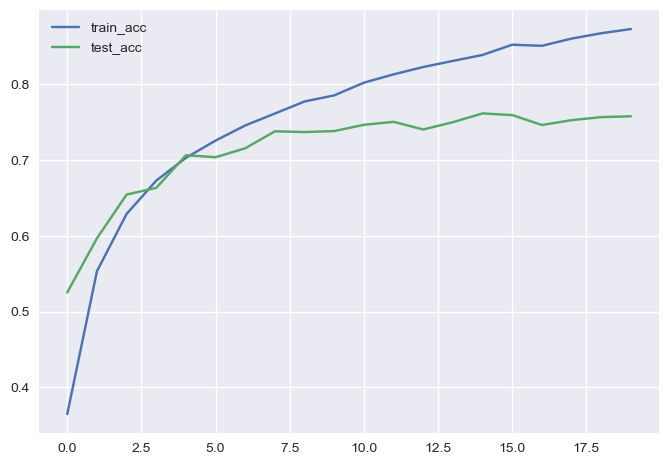

In [7]:
# Plot training and test accuracy
plt.style.use('seaborn')
plt.plot(hist_KDL.history['accuracy'], label='train_acc', color='C0')
plt.plot(hist_KDL.history['val_accuracy'], label='test_acc', color='C1')
plt.legend()

In [8]:
# Build the dense model using the functional API
# input layer
i = Input(shape=x_train[0].shape)

# Convolution Layer
x = Conv2D(16, (3, 3), activation='relu', padding='same')(i)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Dropout Layer
x = Dropout(0.2)(x)
x = Flatten()(x)
 
# Dense layers
x = Dense(4096, activation='relu')(x)

x = Dense(4096, activation='relu')(x)
 
# For output
x = Dense(10, activation='softmax')(x)

# Build model
model = Model(i, x)
 
# model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        9280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 256)         1477

In [9]:
# Compile with learning rate 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [10]:
hist_dense = model.fit(
  x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
391/391 [==============================] - 347s 879ms/step - loss: 1.4872 - accuracy: 0.4547 - val_loss: 1.1469 - val_accuracy: 0.5847
Epoch 2/20
391/391 [==============================] - 323s 825ms/step - loss: 1.0567 - accuracy: 0.6239 - val_loss: 0.9416 - val_accuracy: 0.6676
Epoch 3/20
391/391 [==============================] - 323s 826ms/step - loss: 0.8711 - accuracy: 0.6915 - val_loss: 0.8817 - val_accuracy: 0.6917
Epoch 4/20
391/391 [==============================] - 321s 820ms/step - loss: 0.7307 - accuracy: 0.7417 - val_loss: 0.7977 - val_accuracy: 0.7215
Epoch 5/20
391/391 [==============================] - 322s 824ms/step - loss: 0.6150 - accuracy: 0.7839 - val_loss: 0.7954 - val_accuracy: 0.7286
Epoch 6/20
391/391 [==============================] - 322s 824ms/step - loss: 0.5070 - accuracy: 0.8223 - val_loss: 0.7442 - val_accuracy: 0.7446
Epoch 7/20
391/391 [==============================] - 322s 823ms/step - loss: 0.3979 - accuracy: 0.8576 - val_loss: 0.7838 -

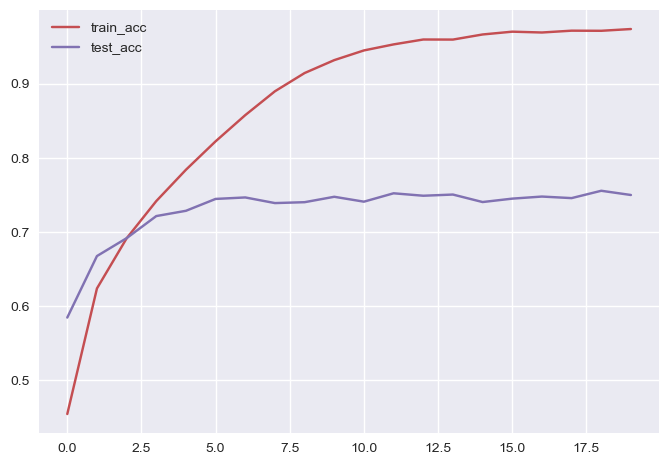

In [11]:
# Plot training and test accuracy
plt.plot(hist_dense.history['accuracy'], label='train_acc', color='C2')
plt.plot(hist_dense.history['val_accuracy'], label='test_acc', color='C3')
plt.legend()

In [12]:
# Build a KDL model with Kronecker rank of 4
# input layer
i = Input(shape=x_train[0].shape)

# Convolution Layer
x = Conv2D(16, (3, 3), activation='relu', padding='same')(i)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Dropout Layer
x = Dropout(0.2)(x)
x = Reshape((64,64))(x)
 
# KDL's (Kronecker rank 4)
x1 = KDLeftLayer(64, activation='relu')(x)
x1 = KDRightLayer(64)(x1)

x2 = KDRightLayer(64, activation='relu')(x)
x2 = KDLeftLayer(64)(x2)

x3 = KDLeftLayer(64, activation='relu')(x) 
x3 = KDRightLayer(64)(x3)

x4 = KDLeftLayer(64, activation='relu')(x)
x4 = KDRightLayer(64)(x4)
 
x = Add()([x1,x2,x3,x4]) # Combine layers before activation
x = ReLU()(x)

x1 = KDLeftLayer(64, activation='relu')(x)
x1 = KDRightLayer(64)(x1)

x2 = KDRightLayer(64, activation='relu')(x)
x2 = KDLeftLayer(64)(x2)

x3 = KDLeftLayer(64, activation='relu')(x) 
x3 = KDRightLayer(64)(x3)

x4 = KDLeftLayer(64, activation='relu')(x)
x4 = KDRightLayer(64)(x4)
 
x = Add()([x1,x2,x3,x4]) 
x = ReLU()(x)

# Another set of KDL's for output (Also Kronecker rank 4)
x1 = KDLeftLayer(2, activation='relu')(x)
x1 = KDRightLayer(5)(x1)

x2 = KDRightLayer(5, activation='relu')(x)
x2 = KDLeftLayer(2)(x2)

x3 = KDLeftLayer(2, activation='relu')(x)
x3 = KDRightLayer(5)(x3)

x4 = KDLeftLayer(2, activation='relu')(x)
x4 = KDRightLayer(5)(x4)

x = Add()([x1,x2,x3,x4])
x = Flatten()(x)
x = Softmax()(x)
model = Model(i, x)
 
# model description
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 16)   448         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 16)  0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 16, 16, 64)   9280        ['max_pooling2d_6[0][0]']        
                                                                                            

                                                                                                  
 kd_right_layer_11 (KDRightLaye  (None, 2, 5)        330         ['kd_left_layer_11[0][0]']       
 r)                                                                                               
                                                                                                  
 kd_left_layer_12 (KDLeftLayer)  (None, 2, 5)        138         ['kd_right_layer_12[0][0]']      
                                                                                                  
 kd_right_layer_13 (KDRightLaye  (None, 2, 5)        330         ['kd_left_layer_13[0][0]']       
 r)                                                                                               
                                                                                                  
 kd_right_layer_14 (KDRightLaye  (None, 2, 5)        330         ['kd_left_layer_14[0][0]']       
 r)       

In [13]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
hist_KDL4 = model.fit(
  x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
391/391 [==============================] - 137s 341ms/step - loss: 1.6545 - accuracy: 0.3946 - val_loss: 1.3174 - val_accuracy: 0.5235
Epoch 2/20
391/391 [==============================] - 119s 305ms/step - loss: 1.2740 - accuracy: 0.5383 - val_loss: 1.1426 - val_accuracy: 0.5890
Epoch 3/20
391/391 [==============================] - 125s 320ms/step - loss: 1.0950 - accuracy: 0.6085 - val_loss: 0.9954 - val_accuracy: 0.6431
Epoch 4/20
391/391 [==============================] - 125s 319ms/step - loss: 0.9870 - accuracy: 0.6489 - val_loss: 0.9536 - val_accuracy: 0.6673
Epoch 5/20
391/391 [==============================] - 118s 303ms/step - loss: 0.8965 - accuracy: 0.6833 - val_loss: 0.8815 - val_accuracy: 0.6899
Epoch 6/20
391/391 [==============================] - 122s 313ms/step - loss: 0.8273 - accuracy: 0.7073 - val_loss: 0.8495 - val_accuracy: 0.7082
Epoch 7/20
391/391 [==============================] - 119s 305ms/step - loss: 0.7678 - accuracy: 0.7292 - val_loss: 0.8051 -

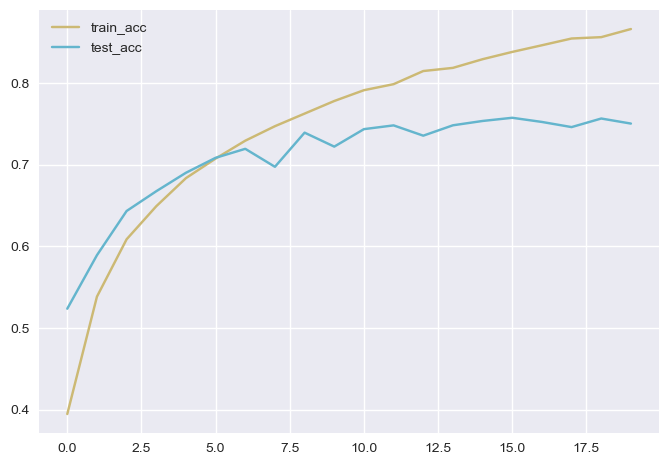

In [15]:
# Plot training and test accuracy
plt.plot(hist_KDL4.history['accuracy'], label='train_acc', color='C4')
plt.plot(hist_KDL4.history['val_accuracy'], label='test_acc', color='C5')
plt.legend()

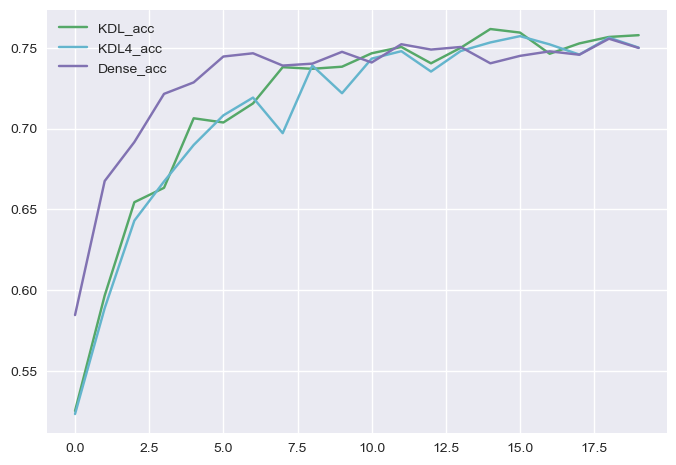

In [16]:
# Plot test accuracy comparison
plt.plot(hist_KDL.history['val_accuracy'], label='KDL_acc', color='C1')
plt.plot(hist_KDL4.history['val_accuracy'], label='KDL4_acc', color='C5')
plt.plot(hist_dense.history['val_accuracy'], label='Dense_acc', color='C3')
plt.legend()